In [1]:
# ckpt_path=''
# ckpt_path = '/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/models/odd_atoll_8115-model-last.pt'
# ckpt_path = "/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/standalone_trainer/082_cfg.exp_targets=['sz_weight']/model-last.pt"
# ckpt_path = "/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/standalone_trainer/051_cfg.exp_targets=['sz_weight']/model-last.pt"
ckpt_path=None
# ckpt_path = "/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/standalone_trainer/interp_mode/114_cfg.exp_targets=['interp_cond_img']/model-last.pt"

In [2]:
# Parameters
ckpt_path = "/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/standalone_trainer/interp_mode/114_cfg.exp_targets=['interp_cond_img']/model-last.pt"


In [3]:
print(ckpt_path)
base_exp_dir='/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/models/interp_mode'
exp_dir_to_cfg_attrs = {
"114_cfg.exp_targets=['interp_cond_img']": {"input_img_sdm_interpolation_mode": "interpolate", "cond_img_sdm_interpolation_mode": "infill"},
"115_cfg.exp_targets=['interp_cond_img']": {"input_img_sdm_interpolation_mode": "infill", "cond_img_sdm_interpolation_mode": "interpolate"},
}
eval_batch = "eval_batch.pt"

/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/standalone_trainer/interp_mode/114_cfg.exp_targets=['interp_cond_img']/model-last.pt


In [4]:
import gc
import itertools
import os
import shutil
from pathlib import Path
import matplotlib.pyplot as plt

import comet_ml
import tensorflow as tf
import torch
import torch.optim as optim
from load_data import load_data
from model import init_model
from rsl_depth_completion.conditional_diffusion.config import cfg as cfg_cls
from rsl_depth_completion.conditional_diffusion.custom_trainer import ImagenTrainer
from rsl_depth_completion.conditional_diffusion.train import train
from rsl_depth_completion.conditional_diffusion.utils import (
    dict2mdtable,
    log_params_to_exp,
)
from rsl_depth_completion.diffusion.utils import set_seed

torch.backends.cudnn.benchmark = True

In [5]:
cfg = cfg_cls(path=cfg_cls.default_file)
cfg.batch_size = 2
cfg.eval_batch_path = eval_batch

for exp_dir, cfg_attrs in exp_dir_to_cfg_attrs.items():
    if exp_dir in ckpt_path:
        cfg.__dict__.update(cfg_attrs)
        break
print(vars(cfg))
set_seed(cfg.seed)

if cfg.is_cluster:
    if not os.path.exists(f"{cfg.tmpdir}/cluster"):
        os.system(f"tar -xvf /cluster/project/rsl/kzaitsev/dataset.tar -C {cfg.tmpdir}")

logdir = Path("./logs") if not cfg.is_cluster else Path(cfg.cluster_logdir)
if cfg.do_overfit:
    logdir = logdir / "standalone_trainer"
else:
    logdir = logdir / "train"

# shutil.rmtree(logdir, ignore_errors=True)

best_params = {
    "kitti": {
        "use_text_embed": True,
        "use_cond_image": True,
        "use_rgb_as_cond_image": False,
    },
    "mnist": {
        "use_text_embed": True,
        "use_cond_image": True,
        "use_rgb_as_cond_image": False,
    },
}

ds_kwargs = best_params[cfg.ds_name]

ds_kwargs["use_rgb_as_text_embed"] = not ds_kwargs["use_rgb_as_cond_image"]
ds_kwargs["include_sdm_and_rgb_in_sample"] = True
ds_kwargs["do_crop"] = True
print(ds_kwargs)

ds, train_dataloader, val_dataloader = load_data(
    ds_name=cfg.ds_name, do_overfit=cfg.do_overfit, cfg=cfg, **ds_kwargs
)

experiment = comet_ml.Experiment(
    api_key="W5npcWDiWeNPoB2OYkQvwQD0C",
    project_name="rsl_depth_completion",
    auto_metric_logging=True,
    auto_param_logging=True,
    auto_histogram_tensorboard_logging=True,
    log_env_details=True,
    log_env_host=False,
    log_env_gpu=True,
    log_env_cpu=True,
    disabled=True,
)

experiment.log_asset("model.py", copy_to_tmp=False)
experiment.log_asset("load_data.py", copy_to_tmp=False)
experiment.log_asset("train.py", copy_to_tmp=False)
experiment.log_asset("config.py", copy_to_tmp=False)

log_params_to_exp(experiment, ds_kwargs, "dataset")
log_params_to_exp(experiment, cfg.params(), "base_config")

print(
    "Number of train samples",
    len(train_dataloader) * train_dataloader.batch_size,
)

unets, model = init_model(experiment, ds_kwargs, cfg)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(
    "Number of parameters in model",
    num_params,
)

trainer = ImagenTrainer(
    model,
    use_lion=False,
    lr=cfg.lr,
    max_grad_norm=1.0,
    fp16=cfg.fp16,
    use_ema=False,
    accelerate_log_with="tensorboard",
    accelerate_logging_dir="logs",
)
trainer.accelerator.init_trackers("train_example")
trainer.load(ckpt_path)
;

{'do_overfit': True, 'do_lr_schedule': True, 'do_early_stopping': True, 'num_epochs': 1500, 'lr': 5e-05, 'train_one_epoch': False, 'sampling_freq': 150, 'batch_size': 2, 'do_save_model': True, 'num_workers': 2, 'eval_batch_path': 'eval_batch.pt', 'input_img_sdm_interpolation_mode': 'interpolate', 'cond_img_sdm_interpolation_mode': 'infill'}
{'use_text_embed': True, 'use_cond_image': True, 'use_rgb_as_cond_image': False, 'use_rgb_as_text_embed': True, 'include_sdm_and_rgb_in_sample': True, 'do_crop': True}


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


/opt/miniconda3/envs/ssdc/lib/python3.10/site-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(


Number of train samples 2
The base dimension of your u-net should ideally be no smaller than 128, as recommended by a professional DDPM trainer https://nonint.com/2022/05/04/friends-dont-let-friends-train-small-diffusion-models/
Number of parameters in model 8921330


checkpoint loaded from /media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/logs/standalone_trainer/interp_mode/114_cfg.exp_targets=['interp_cond_img']/model-last.pt


''

In [6]:
eval_batch = ds.eval_batch
# path = "eval_batch_rand_sdm.pt"
# loaded_eval_batch = torch.load(path)
# loaded_eval_batch = {
#     k: v[: cfg.batch_size] for k, v in loaded_eval_batch[cfg.input_res].items()
# }
# eval_batch["cond_img"] = loaded_eval_batch["cond_img"]
# eval_batch["text_embed"] = loaded_eval_batch["text_embed"]

In [7]:
from rsl_depth_completion.conditional_diffusion.utils import rescale_img_to_zero_one_range


def plot_result(samples):
    fig, axs = plt.subplots(
        len(samples[0]) if len(samples[0]) > 1 else 2, 5, figsize=(12, 5)
    )
    fig.suptitle(f"Original cond_scale: {cfg.cond_scale}")
    for i in range(len(samples[0])):
        axs[i, 0].imshow(samples[0][i].permute(1, 2, 0).cpu().numpy())
        axs[i, 1].imshow(eval_batch["cond_img"][i].permute(1, 2, 0).cpu().numpy())
        rgb = eval_batch["rgb"][i].permute(1, 2, 0).cpu().numpy()
        rgb = rescale_img_to_zero_one_range(rgb)
        axs[i, 2].imshow(rgb)
        sdm = eval_batch["sdm"][i].permute(1, 2, 0).cpu().numpy()
        sdm = rescale_img_to_zero_one_range(sdm)
        axs[i, 3].imshow(sdm)
        axs[i, 4].imshow(eval_batch["input_img"][i].permute(1, 2, 0).cpu().numpy())
        if i == 0:
            axs[i, 0].set_title("sampled")
            axs[i, 1].set_title("cond_img")
            axs[i, 2].set_title("image for text_embed")
            axs[i, 3].set_title("sparse depth")
            axs[i, 4].set_title("input image")
        axs[i, 0].set_ylabel(f"sample {i}")

In [8]:
torch.corrcoef(eval_batch["text_embed"].squeeze(1))

tensor([[1.0000, 0.8572],
        [0.8572, 1.0000]])

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

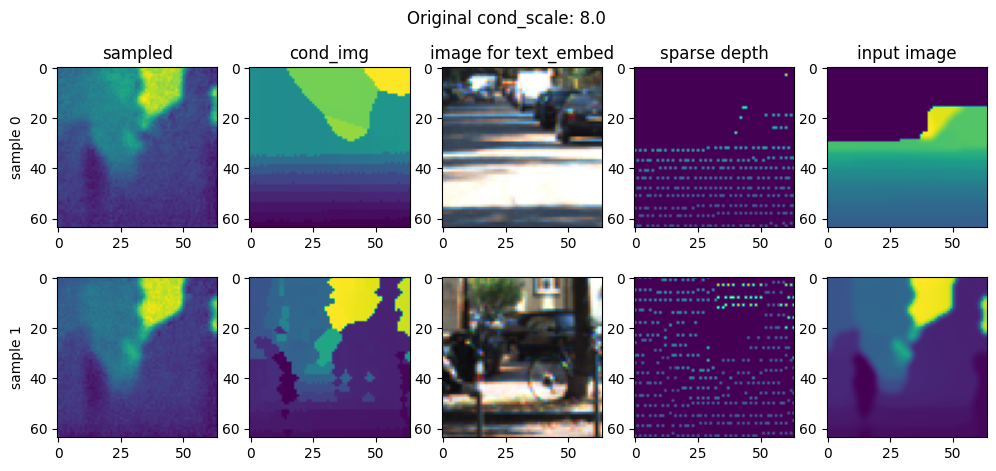

In [9]:
samples = trainer.sample(
    text_embeds=eval_batch["text_embed"],
    cond_images=eval_batch["cond_img"],
    # text_embeds=eval_batch["text_embed"][0].unsqueeze(0),
    # cond_images=eval_batch["cond_img"][0].unsqueeze(0),
    cond_scale=0,
    # cond_scale=cfg.cond_scale,
    batch_size=cfg.batch_size,
    stop_at_unet_number=None,
    return_all_unet_outputs=True,
)
plot_result(samples)

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

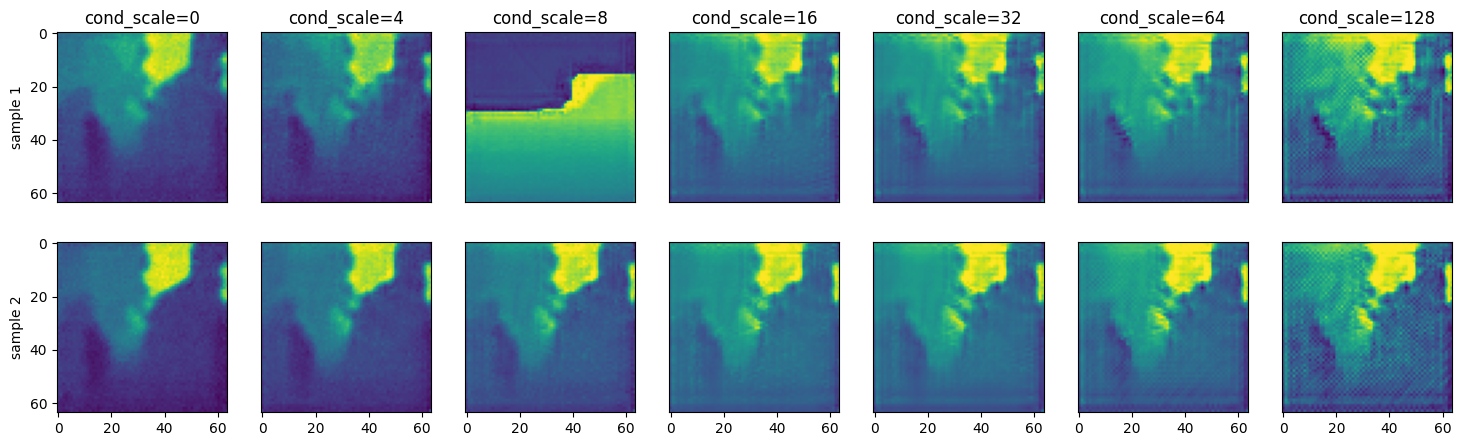

In [10]:
def compare_diff_cond_scales(trainer):
    cond_scales = list([0, 4, 8, 16, 32, 64, 128])
    # cond_scales = list([8,16,128,1000])
    # cond_scales = list([0,1,2,3,4,5,6])
    # cond_scales = list(range(7,14))
    fix, axs = plt.subplots(max(cfg.batch_size, 2), len(cond_scales), figsize=(18, 5))
    for i, cond_scale in enumerate(cond_scales):
        samples = trainer.sample(
            text_embeds=eval_batch["text_embed"],
            cond_images=eval_batch["cond_img"],
            cond_scale=cond_scale,
            batch_size=cfg.batch_size,
            stop_at_unet_number=None,
            return_all_unet_outputs=True,
        )
        for sample_idx in range(cfg.batch_size):
            axs[sample_idx, i].imshow(
                samples[0][sample_idx].permute(1, 2, 0).cpu().numpy()
            )
            axs[0, i].set_title(f"{cond_scale=}")
            if sample_idx == 0:
                axs[sample_idx, i].set_xticks([])
            # if sample_idx!=0:
            #     axs[sample_idx, i].set_yticklabels([])
            #     axs[sample_idx, i].set_yticks([])
            #     axs[sample_idx, i].set_xticklabels([])
            if i != 0:
                axs[sample_idx, i].set_yticklabels([])
                axs[sample_idx, i].set_yticks([])
        # break
    axs[0, 0].set_ylabel("sample 1")
    axs[1, 0].set_ylabel("sample 2")
    plt.show()


compare_diff_cond_scales(trainer)